In [1]:
import pandas as pd
import numpy as np
from langdetect import detect

import json
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import seaborn as sns
import re
import math
from collections import defaultdict, Counter

import utils
import required_variables
# from graph import create_graph

# Params & Vars

In [2]:
CHOSEN_CATEGORIES = True
LABELS_NEEDED_BEFORE = 626
ONLY_PARENT_CATEGORY = False
N_TO_SELECT = 10

# Data 

In [3]:
df = pd.read_csv('../data/en_data.csv', encoding='utf-8')

In [4]:
df = df[['sreid', 'srenext', 'textrecord', 'ocms', 'culture', 'place', 'pub.date', 'field.date', 'pub.lang']]

In [5]:
df['ocms_list'] = df['ocms'].str.split()
df['ocms_list'] = df['ocms_list'].apply(lambda x: [int(i) for i in x])

In [6]:
df.head(2)

,sreid,srenext,textrecord,ocms,culture,place,pub.date,field.date,pub.lang,ocms_list
0,aa01-000-000178,aa01-000-000186,"Before the 1900s, Koreans lived as subsistence...",241 433,Korea,Korea,NaN,no date,English,"[241, 433]"
1,aa01-001-000341,aa01-001-000357,{{245}} “Korea is richly endowed with fruits o...,245,Korea,Korea,NaN,1890-1905,English,[245]


In [7]:
ocms_counts = utils.get_ocm_counts(df, id_to_category if ONLY_PARENT_CATEGORY else None, 
                                   limit=LABELS_NEEDED_BEFORE)

In [8]:
chosen_categories = [220, 240]

# Needed Functions


In [9]:
def top_n_count(ocm_id, n=400):
    top_400 = any([ocm_id == y[0] for y in ocms_counts.most_common(n)])
    if not top_400:
        return top_400, None, None
    x_i = list(map(lambda x:x[0], ocms_counts.most_common(n))).index(ocm_id)
    return top_400, x_i , ocms_counts[ocm_id]

In [26]:
def df_per_cat(df, cat):
    df_cat = df[ df['ocms'].apply(lambda x: str(cat) in x.split()) ]
    return df_cat


def df_per_subcat(df, cat, with_subcat_only=False):    
    parent_cat = utils.get_parent_category_i(cat)
    
    if with_subcat_only:
        # overlap of cat with  subcategories ONLY.
        df_cat = df[ df['ocms_list'].apply(lambda x: 
                                           cat in x and np.all([parent_cat == utils.get_parent_category_i(i)  for i in x]) )] # all from same parent cat.
        
    else: 
        # overlap of cat with others ONLY.
        df_cat = df[ df['ocms_list'].apply(lambda x: 
                                           cat in x and np.all([parent_cat != utils.get_parent_category_i(i)
                                                   for i in x if cat != i]) )] # all others not from same parent cat.
        
    return df_cat

In [11]:
def df_per_parent_cat(df, cat):
    parent_cat = utils.get_parent_category_i(cat)
    
    result = []
    for ocm in range(parent_cat, parent_cat+10):
        
        count = top_n_count(ocm, n=10000000)
        # print(count, ocm)
        if not count[-1]:
            continue
            
        subcat_df = df_per_cat(df, ocm)
    
        no_overlap = len(subcat_df[ subcat_df['ocms_list'].apply(lambda x: x[0] == ocm and len(x) == 1) ])
        
        overlap_subcat =  len(df_per_subcat(df, ocm, with_subcat_only=True)['ocms_list']) - no_overlap
        
        rest_overlap = count[-1] - no_overlap - overlap_subcat
        
        result.append({
            'ocm': ocm,
            'count': count[-1],
            # 'overlap_all': overlap_with_all,
            'rest_overlap': rest_overlap,
            'no_overlap': no_overlap,
            'overlap_subcat': overlap_subcat,
        })
        
        
    return pd.DataFrame(result)

In [24]:
def plot_subcat(df, 
                cat,
                count=False,
                title='',
               save=False):
    fig = go.Figure(
        # layout_title=f'Overlap of {cat}.',
        layout_title_x=0.5,
        layout_xaxis_title='OCM Code',
        layout_yaxis_title='Occurences',
        layout_margin=dict(l=0, r=0, t=30, b=10),
        layout_height=400,
    )
    
    xaxis = [f'{required_variables.id_to_label[i]} ({i})'  for i in df['ocm']]
    
    if count:
        fig.add_bar(x=xaxis, y=df['count'], name='Count',)
        fig.add_bar(x=xaxis, y=df['rest_overlap'], name='rest_overlap')
        
    fig.add_bar(x=xaxis, y=df['no_overlap'], name='no_overlap', )
    fig.add_bar(x=xaxis, y=df['overlap_subcat'], name='overlap_subcat', )
    
    fig.show()
    
    if save:
        fig.write_image(title + '.png')
    

# Visualization: Chosen Cats.

In [13]:
def df_chosen_cats(df):
    result = {}
    for cat in chosen_categories:
        result[cat] = [len(df[df['ocms'].apply(lambda x: len(x.split()) == 1  and str(cat) == x)])]
    print(result)
    return pd.DataFrame(result)

{220: [50], 240: [8]}


<Axes: >

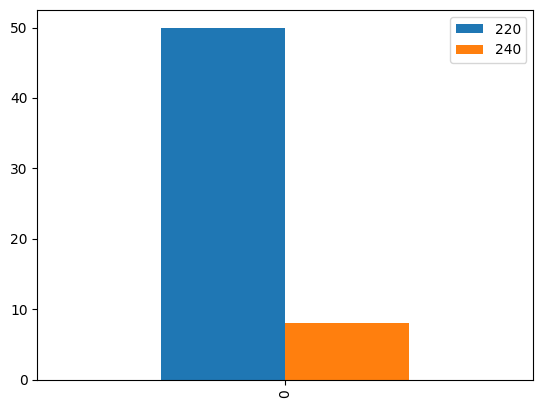

In [14]:
df_chosen_cats(df).plot.bar()

# Visualization: Subcats.

In [15]:
top_n_count(240)

(True, 281, 214)

In [25]:
data = []
for cat in chosen_categories:
    data.append(df_per_parent_cat(df, cat))
    plot_subcat(data[-1], cat, count=False, save=True, title=f'cat_{cat}_overlap')
    plot_subcat(data[-1], cat, count=True)
    
# pd.concat(data)